# -----------------------------------------------
# Alba ORDOÑEZ 
# -----------------------------------------------

# Abstract
This notebook describes the strategy used for developing a binary classification algorithm in a data challenge where the main goal was to detect whether an image contained some property or not. Given that convolution neural networks are the state of the art methods used for this kind of task, I built a classification algorithm based on these architectures.  More thorough explanations about the results presented in this notebook are given in the associated report.

# Libraries import

In [1]:
# Library import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rnd
import math
import os
import sys
import PIL
from PIL import Image
import time
import matplotlib.image as mpimg
from vis.visualization import visualize_cam, visualize_saliency, overlay
from vis.utils import utils
import matplotlib.cm as cm
from sklearn import metrics
import seaborn as sns
sns.set()
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from keras import backend as K
from keras import applications
from keras import models
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation, Conv2D, MaxPooling2D, LeakyReLU, AveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from keras.initializers import he_normal
from keras.applications.resnet50 import ResNet50, preprocess_input

Using TensorFlow backend.


# Loading and investigating the data

In [0]:
# Loading the data
!wget https://www.dropbox.com/s/486li09u91zyjdm/db_train.raw?dl=1
!wget https://www.dropbox.com/s/d2hsorvtla3rtf9/label_2019_train.txt?dl=1
!wget https://www.dropbox.com/s/qonk627t2557utz/db_val.raw?dl=1

!mv db_train.raw?dl=1 db_train.raw
!mv db_val.raw?dl=1 db_val.raw
!mv label_2019_train.txt?dl=1 label_2019_train.txt

train_images_fname = 'db_train.raw'
train_labels_fname = 'label_2019_train.txt'

val_images_fname    = 'db_val.raw'

# number of images
num_train_images = 116157
num_valid_images = 27013

# size of the images 56*56 pixels in RGB levels
image_dim = 56 * 56 * 3

train_images_label = np.loadtxt(train_labels_fname, dtype=np.float64)

with open(train_images_fname, 'rb') as f:
    #train_images_data = np.fromfile(f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.float32)
    train_images_data = np.fromfile(f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.uint8)
    train_images_data = train_images_data.reshape(num_train_images, image_dim)
    
with open(val_images_fname, 'rb') as f:
    val_images_data = np.fromfile(f, dtype=np.uint8, count=num_valid_images * image_dim).astype(np.uint8)
    val_images_data = val_images_data.reshape(num_valid_images, image_dim)

## Identifying duplicate images

In order to detect the duplicates, the solution I chose was to calculate a hash for each individual image in the training set, store the hashes in a list to find out the repeated ones. The are several perceptual hashing algorithms but the one I picked here was the dHash algorithm presented below.

In [0]:
# Hashing function
def dhash(image, hash_size = 8):
  # Grayscale and shrink the image in one step.
  image = image.convert('L').resize(
      (hash_size, hash_size + 1),
      Image.ANTIALIAS,
  )
  #image = image.convert('L').resize(
   #   (hash_size + 1, hash_size),
    #  Image.ANTIALIAS,
  #)
  pixels = list(image.getdata())
  # Compare adjacent pixels.
  difference = []
  for row in range(hash_size):
      for col in range(hash_size):
          pixel_left = image.getpixel((col, row))
          #pixel_right = image.getpixel((col + 1, row))
          pixel_right = image.getpixel((col, row + 1))
          difference.append(pixel_left > pixel_right)
  # Convert the binary array to a hexadecimal string.
  decimal_value = 0
  hex_string = []
  for index, value in enumerate(difference):
      if value:
          decimal_value += 2**(index % 8)
      if (index % 8) == 7:
          hex_string.append(hex(decimal_value)[2:].rjust(2, '0'))
          decimal_value = 0
  return ''.join(hex_string)

Let's hash the images in the training and validation sets to figure out how many unique images we have in each of the datasets.

In [9]:
# Hashing data in the training set
L_dhash_train = []

for i in range(train_images_data.shape[0]):
  L_dhash_train.append(dhash(Image.fromarray(train_images_data[i].reshape(56, 56,3), 'RGB')))

print("Total number of hashes training dataset:", len(L_dhash_train))
print("Unique hashes in training dataset:", len(np.unique(L_dhash_train)))

# Hashing data in the provided validation set
L_dhash_val = []

for i in range(val_images_data.shape[0]):
  L_dhash_val.append(dhash(Image.fromarray(val_images_data[i].reshape(56, 56,3), 'RGB')))

print("Total number of hashes validation dataset:", len(L_dhash_val))
print("Unique hashes in validation dataset:", len(np.unique(L_dhash_val)))


Total number of hashes training dataset: 116157
Unique hashes in training dataset: 115903
Total number of hashes validation dataset: 27013
Unique hashes in validation dataset: 26992


By examining the frequency of the hashes, it appears that there are some images that are duplicated more than 2 times in the training set.

In [5]:
# Examine hashes
print("More frequent hashes in training: ", Counter(L_dhash_train).most_common(10))
print("More frequent hashes in validation:", Counter(L_dhash_val).most_common(4))

More frequent hashes in training:  [('c17c0903ffeed63c', 3), ('d2fcc0003d1987c0', 3), ('db3e0093ff3a37fd', 2), ('68ffc343febe6619', 2), ('647c08816dbcfafe', 2), ('b47d0040ffad3c7e', 2), ('43b92a03fe9bc57c', 2), ('383c80c3f6fe2630', 2), ('debd0040feaf06fc', 2), ('727f0ec87dbde07d', 2)]
More frequent hashes in validation: [('247c0880ff7fe7f9', 2), ('647c0181fffc6038', 2), ('01ac8681fffdb3be', 2), ('c0bc10001cf9e1d3', 2)]


Let's display some of these duplications.

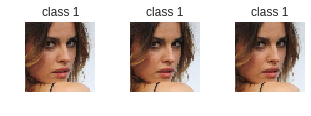

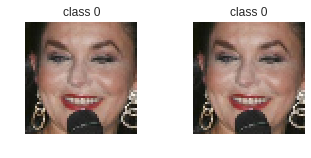

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 5),squeeze = False)
fig.subplots_adjust(hspace = 0.5,wspace = 0.5)

l=0
for row in axes:
  for ax in row:
      i = list(np.where(np.asarray(L_dhash_train) == "d2fcc0003d1987c0")[0])[l]
      ax.set_title(f"class {int(train_images_label[i])}")
      ax.imshow(train_images_data[i].reshape(56, 56,3).astype(np.uint8))
      ax.axis('off')
      l = l + 1      
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5),squeeze = False)
fig.subplots_adjust(hspace = 0.5,wspace = 0.5)

l=0
for row in axes:
  for ax in row:
      i = list(np.where(np.asarray(L_dhash_train) == "647c08816dbcfafe")[0])[l]      
      ax.set_title(f"class {int(train_images_label[i])}")
      ax.imshow(train_images_data[i].reshape(56, 56,3).astype(np.uint8))
      ax.axis('off')
      l = l + 1      

It also turns out that there are few detected duplicate images in the training set that are associated to labels 0 and 1. Let's try to find out which are these images.

In [7]:
# Hashing data in the training set ans separating cases associated to laebls 0 and 1
X0 = train_images_data[train_images_label==0]
X1 = train_images_data[train_images_label==1]

X0_dhash = []
X1_dhash = []

for i in range(X0.shape[0]):
  X0_dhash.append(dhash(Image.fromarray(X0[i].reshape(56, 56,3), 'RGB')))

for i in range(X1.shape[0]):
  X1_dhash.append(dhash(Image.fromarray(X1[i].reshape(56, 56,3), 'RGB')))

print("Total number of hashes training dataset (label 0):", len(X0_dhash))
print("Unique hashes in training dataset (label 0):", len(np.unique(X0_dhash)))

print("Total number of hashes training dataset (label 1):", len(X1_dhash))
print("Unique hashes in training dataset (label 1):", len(np.unique(X1_dhash)))

intersept_dhash = set(X0_dhash).intersection(set(X1_dhash))
X0_ind = [i for i in range(len(X0)) if X0_dhash[i] in intersept_dhash]
X1_ind = [i for i in range(len(X1)) if X1_dhash[i] in intersept_dhash]
combi_dhash = [(i,j) for i in X0_ind for j in X1_ind if X0_dhash[i] == X1_dhash[j]]

Total number of hashes training dataset (label 0): 47269
Unique hashes in training dataset (label 0): 47176
Total number of hashes training dataset (label 1): 68888
Unique hashes in training dataset (label 1): 68736


Let's display the images that are both flagged as class 0 and 1 together with their associated difference.

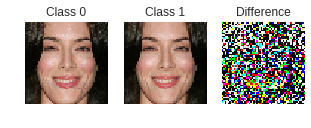

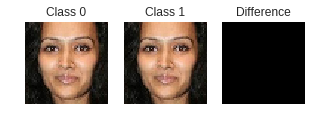

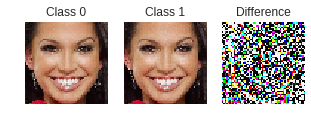

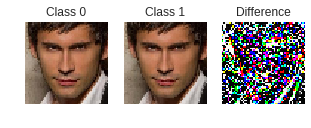

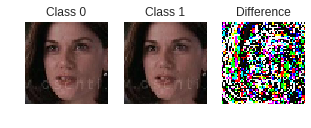

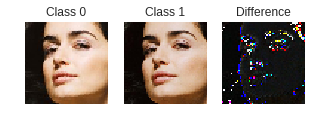

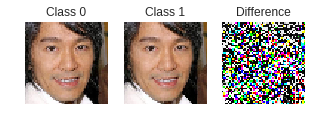

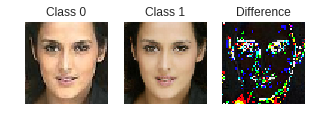

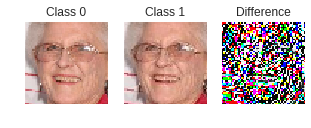

In [8]:
for i in range(len(combi_dhash)):
  idx1 = combi_dhash[i][0]
  idx2 = combi_dhash[i][1]
  fig = plt.figure(figsize=(5,5))
  plt.subplot(131)
  plt.axis('off')
  plt.imshow(X0[idx1].reshape(56, 56,3).astype(np.uint8))
  plt.title("Class 0")
  plt.subplot(132)
  plt.axis('off')
  plt.imshow(X1[idx2].reshape(56, 56,3).astype(np.uint8))
  plt.title("Class 1")
  plt.subplot(133)
  plt.axis('off')
  plt.imshow((X0[idx1]-X1[idx2]).reshape(56, 56,3).astype(np.uint8))
  plt.title("Difference")    

Given the characteristics of the images that are both flagged as 0 and 1 and their associated differences, I could not really conclude on which type of hidden property was behind the faces labelled as 1. Moreover, there is one image which is an exact duplicate and is labelled 0 and 1. This might point out to the fact that the labelling is performed automatically and there might be some errors in this process. For this reason, I decided to build a new training set that excluded all the duplicated images.


## Building train, validation and test sets for modelling

In [9]:
# Indices to keep in the new training set
L_dhash_train_duplicates = [x[0] for x in Counter(L_dhash_train).most_common(252)]
strange_indices = [66, 79, 83, 163, 165, 200, 220, 231, 240]

idx1_todelete_train = []
for strange_index in strange_indices:
  idx1_todelete_train.append((np.where(np.asarray(L_dhash_train) == L_dhash_train_duplicates[strange_index])[0]))
  
train_indices = np.arange(len(train_images_data))
idx_tokeep_train = list(set(train_indices) - set(np.asarray(idx1_todelete_train).flatten()))

duplicates_indices = np.arange(252)
duplicates_indices = list(set(duplicates_indices) - set(strange_indices))

idx2_todelete_train = []
for duplicates_index in duplicates_indices:
  idx2_todelete_train.append((np.where(np.asarray(L_dhash_train) == L_dhash_train_duplicates[duplicates_index])[0][1:]))

idx2_todelete_train = [idx2_todelete_train[x].tolist() for x in range(len(idx2_todelete_train))]
idx2_todelete_train = [item for sublist in idx2_todelete_train for item in sublist]

idx2_todelete_train
idx_tokeep_train = list(set(idx_tokeep_train) - set(idx2_todelete_train))
print("Number of images to keep in training:" , len(idx_tokeep_train), "/", train_images_data.shape[0])


Number of images to keep in training: 115894 / 116157


In [10]:
# Verifying that we have now unique images in the new training set
new_train_images_data = train_images_data.copy()
new_train_images_data = train_images_data[idx_tokeep_train]

# Train
print(new_train_images_data.shape)
L_dhash_new_train = []

for i in range(new_train_images_data.shape[0]):
  L_dhash_new_train.append(dhash(Image.fromarray(new_train_images_data[i].reshape(56, 56,3), 'RGB')))

print("Total number of hashes training dataset:", len(L_dhash_new_train))
print("Unique hashes in training dataset:", len(np.unique(L_dhash_new_train)))

# Setting proper labels for new training set
new_train_images_label = train_images_label.copy()
new_train_images_label = train_images_label[idx_tokeep_train]

(115894, 9408)
Total number of hashes training dataset: 115894
Unique hashes in training dataset: 115894


In [11]:
train_label_0 = new_train_images_label[new_train_images_label==0]
train_label_1 = new_train_images_label[new_train_images_label==1]

print(f"Number samples in class 0 : {len(train_label_0)}  \
({round(100 * len(train_label_0) / len(new_train_images_label),2)} %)")
print(f"Number samples in class 1 : {len(train_label_1)} \
({round(100 * len(train_label_1) / len(new_train_images_label),2)} %)")

Number samples in class 0 : 47167  (40.7 %)
Number samples in class 1 : 68727 (59.3 %)


It can be noticed that classes 0 and 1 are slightly unbalanced, with more samples in class 1 than 0.

In [0]:
# create train and test datasets

train_data = new_train_images_data.reshape(new_train_images_data.shape[0], 56, 56, 3)

x_train, x_test, y_train, y_test = train_test_split(train_data, new_train_images_label, 
                                                    test_size=0.3,                                                     
                                                    random_state=42)

# create train and validation datasets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.15,                                                   
                                                  random_state=42)

# Experimenting with several CNN models 


## Useful functions

In [0]:
# Performance measure for model evaluation
def compute_pred_score(y_true, y_pred):
    y_true = np.round(y_true)
    y_pred = np.round(y_pred)
    if(y_true.shape[0] != y_pred.shape[0]):
        raise Exception("y_pred and y_true must have the same size")
    tmp = np.unique(y_pred)
    if(tmp.shape[0] > 2):
        raise("y_pred should only contain 0 and 1")
        
    if(tmp.shape[0] == 1):
        if(tmp[0] != 0 and tmp[0] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    else:
        if(tmp[0] != 0 and tmp[1] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    
    y0 = (y_true == 0)
    y1 = (y_true == 1)
    
    acc1 = np.mean(1-y_pred[y0])
    acc2 = np.mean(y_pred[y1])
    res = (acc1+acc2)/2
    
    return res.astype(np.float32)

In [0]:
# Custom metric for Keras model run: weighted average accuracy for each class
def w_acc(y_true, y_pred):    
    loss = tf.py_func(func=compute_pred_score, inp=[y_true, y_pred], Tout=tf.float32)
    return loss

In [0]:
# Workaround to apply flow on test data for prediction with generator
def test_gen(x_test, val_datagen, batch_size):
    Y_trash = np.ones(x_test.shape[0])
    flow = val_datagen.flow(x_test, Y_trash, shuffle=False, batch_size=batch_size, seed=1)
    for X,Y in flow:
      yield X #ignore Y

In [0]:
# Dictionnary created for saving the results of each modelling
def create_dict(history, start_time, idx):
  t_dict = {'epoch_index': idx,
              'epoch_time (s)': [np.round(time.time() - start_time, 2)],
              'acc': [history.history['acc'][0]],
              'loss': [history.history['loss'][0]],
              'w_acc': [history.history['w_acc'][0]],              
              'val_acc': [history.history['val_acc'][0]],
              'val_loss': [history.history['val_loss'][0]],
              'val_w_acc': [history.history['val_w_acc'][0]],                  
              'test_w_acc (every 5 epochs)': ['.']
                  }    
  return t_dict

In [0]:
# Save model performance
def run_cnn_model(model_name, train_generator, train_steps_per_epoch,
                  val_generator, val_steps_per_epoch, val_datagen,
                  x_test, test_steps_per_epoch,
                  model, n_epochs = 1):
  test_score = []
  tmp_score = 0  

  df = pd.DataFrame(columns=['epoch_index','epoch_time (s)', 'acc', 'loss','w_acc'
                'val_acc', 'val_loss','val_w_acc','test_w_acc (every 5 epochs)'])

  for i in np.arange(n_epochs):  
    start_time = time.time()
    history = model.fit_generator(train_generator, 
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data= val_generator, 
                                validation_steps=val_steps_per_epoch,
                                epochs= 1, verbose=1)

    tmp_dict = create_dict(history, start_time,i)
    df_tmp = pd.DataFrame(tmp_dict)
    df = df.append(df_tmp)


    if (i == 0):
      tmp_loss = df_tmp['val_loss'][0]

    if (df_tmp['val_w_acc'][0] > tmp_score and df_tmp['val_loss'][0] < tmp_loss):
      print(tmp_score, df_tmp['val_w_acc'][0])
      tmp_score = df_tmp['val_w_acc'][0]
      model.save(f'{model_name}.h5')

    if (i == n_epochs - 1):
      model.save(f'{model_name}_final.h5')        

    if (i % 5 == 0):        
      pred=model.predict_generator(test_gen(x_test, val_datagen, batch_size), steps=test_steps_per_epoch, verbose=1)        
      acc_test = compute_pred_score(y_test[: test_steps_per_epoch * batch_size], np.round(pred))        
      print('The score on the test data : %s' % acc_test)    
      df.loc[:,'test_w_acc (every 5 epochs)'].replace(['.'], [acc_test], inplace=True)
    else:
      df.loc[:,'test_w_acc (every 5 epochs)'].replace(['.'], ['..'], inplace=True)


    df.to_csv(f'History_{model_name}.csv')  

In [0]:
# Display model performance
def model_history_plot(df, n_epochs, title="CNN performance"):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
  t = f.suptitle(f'{title}', fontsize=12)
  f.subplots_adjust(top=0.85, wspace=0.3)

  epochs = list(range(0,n_epochs))
  ax1.plot(epochs, df['acc'], label='Train Accuracy')
  ax1.plot(epochs, df['val_acc'], label='Validation Accuracy')
  ax1.set_xticks(epochs)
  ax1.set_ylabel('Accuracy Value')
  ax1.set_xlabel('Epoch')
  ax1.set_title('Accuracy')
  l1 = ax1.legend(loc="best")  
  #ax1.set_xticks(np.arange(0, 30, 5))


  ax2.plot(epochs, df['loss'], label='Train Loss')
  ax2.plot(epochs, df['val_loss'], label='Validation Loss')
  ax2.set_xticks(epochs)
  ax2.set_ylabel('Loss Value')
  ax2.set_xlabel('Epoch')
  ax2.set_title('Loss')
  l2 = ax2.legend(loc="best")
  #ax2.set_xticks(np.arange(0, 30, 5))


  ax3.plot(epochs, df['w_acc'], label='Train Score')
  ax3.plot(epochs, df['val_w_acc'], label='Validation Score')
  ax3.set_xticks(epochs)
  ax3.set_ylabel('Average accuracy Value')
  ax3.set_xlabel('Epoch')
  ax3.set_title('Average accuracy')
  l3 = ax3.legend(loc="best")
  #ax3.set_xticks(np.arange(0, 30, 5))
  
  return f

## CNN model from scratch

I started building a basic CNN model and tried to further improve the obtained results by using regularization and image augmentation as described below. Subsequently, I applied different strategies of transfer learning based on the well known ResNet-50 model. For more details about that, please refer to the report.

### Basic CNN (B1)

In [0]:
input_shape = (56, 56, 3)
X_in = Input(shape = input_shape, name='Input')
X = Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape)(X_in)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Conv2D(64, kernel_size=(3, 3), activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Conv2D(128, kernel_size=(3, 3), activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X_out = Dense(1, activation='sigmoid')(X)

model = Model(inputs=X_in, outputs=X_out)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', w_acc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 56, 56, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 54, 54, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 64)        9280      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 128)         0         
__________

In [0]:
BATCH_SIZE = 124
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size
test_steps_per_epoch = x_test.shape[0] // batch_size

# Create train generator
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size= batch_size, seed=1)

# Create validation generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = train_datagen.flow(x_val, y_val, shuffle=False, batch_size=BATCH_SIZE, seed=1)     


In [0]:
# Run basic cnn model
run_cnn_model('basic_cnn', train_generator, train_steps_per_epoch,
                  val_generator, val_steps_per_epoch, val_datagen,
                  x_test, test_steps_per_epoch,
                  model, n_epochs = 15)

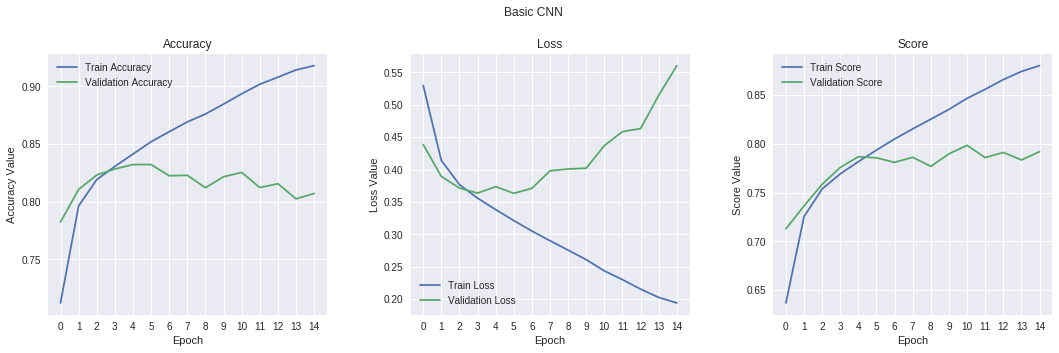

In [0]:
# Read saved history data from basic cnn model
df = pd.read_csv('History_basic_cnn.csv')
f = model_history_plot(df, n_epochs=15, title="Basic CNN")

In the plot showing the model accuracies and errors, it clearly appears that after 3-4 epochs the 
model starts overfitting on the training data with a steep increase in the validation loss and in the training accuracies. There is not much change in the curve of the validation data which stabilizes around 78-79% average accuracy. Let’s try to further improve upon this model.


### Basic CNN with regularization (B2)

In [0]:
input_shape = (56, 56, 3)
X_in = Input(shape = input_shape, name='Input')
X = Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape)(X_in)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Conv2D(64, kernel_size=(3, 3), activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Conv2D(128, kernel_size=(3, 3), activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.3)(X)
X_out = Dense(1, activation='sigmoid')(X)

model = Model(inputs=X_in, outputs=X_out)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', w_acc])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 56, 56, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 54, 54, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)        9280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 128)       73856     
___________________________

In [0]:
# Run regularized cnn model
run_cnn_model('basic_cnn_reg', train_generator, train_steps_per_epoch,
                  val_generator, val_steps_per_epoch, val_datagen, 
                  x_test, test_steps_per_epoch,
                  model, n_epochs = 15)

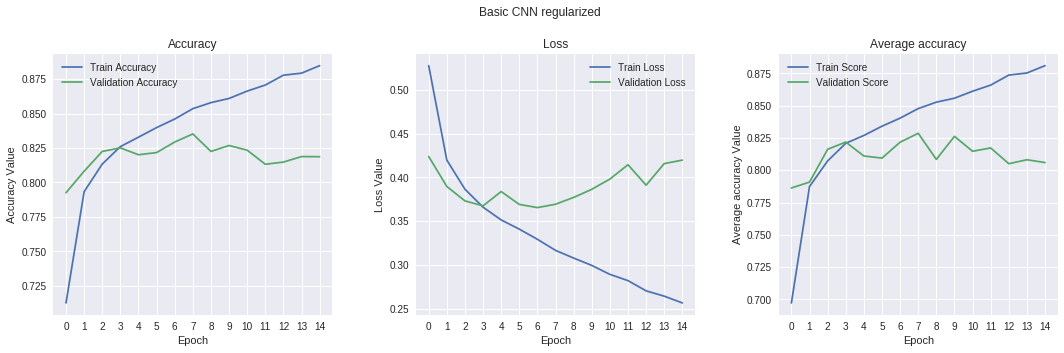

In [0]:
# Read saved history data from regularized cnn model
df = pd.read_csv('History_basic_cnn_reg.csv')
f = model_history_plot(df, n_epochs=15, title="Basic CNN regularized")

It clearly appears from the learning curves that with 15 epochs I still end up overfitting the model even though I have a better validation average accuracy around 82 %. The reason for model overfitting might be related to the fact that I may not have enough training data and the model keeps seeing the same instances over time across each epoch. A solution for that would be to implement a data augmentation strategy where the existing training data would also include slight variations of the original images as presented in the following.

### Basic CNN regularized with image augmentation (B3)

In [0]:
# Create new train generator with image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,  zoom_range=0.1, rotation_range=10,
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size= batch_size, seed=1)

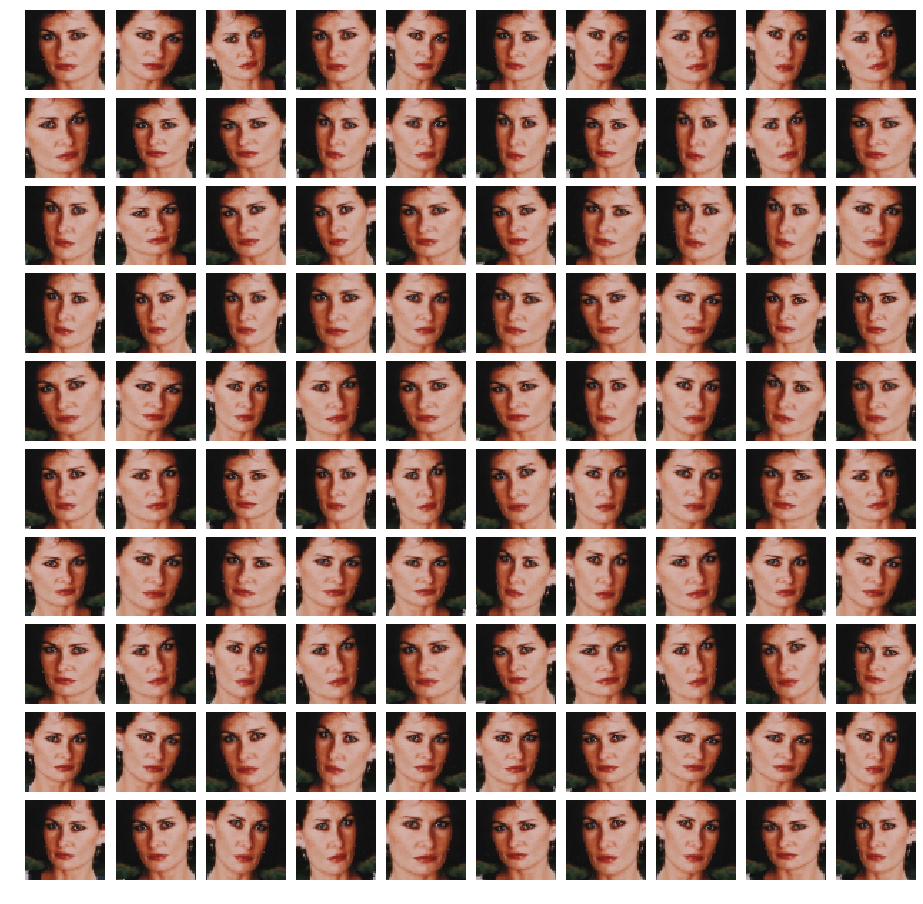

In [0]:
# Display generated images
n = 100
i = 0

img_id = 2595
face_generator = train_datagen.flow(train_data[img_id:img_id+1], y_train[img_id:img_id+1],
                                   batch_size=1)

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(16, 16),squeeze = False)
fig.subplots_adjust(hspace = 0.1,wspace = 0.1)
face = [next(face_generator) for i in range(0,n)]
for row in axes:
  for ax in row:
      ax.axis('off')      
      ax.imshow(face[i][0][0])
      i = i + 1

In [0]:
# Same model as basic CNN (with regularization) but with a lower learning rate of 1e-4 (default: 1e-3)
input_shape = (56, 56, 3)
X_in = Input(shape = input_shape, name='Input')
X = Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape)(X_in)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Conv2D(64, kernel_size=(3, 3), activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Conv2D(128, kernel_size=(3, 3), activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.3)(X)
X_out = Dense(1, activation='sigmoid')(X)

model = Model(inputs=X_in, outputs=X_out)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy', w_acc])

In [0]:
# Run basic cnn model with image augmentation
run_cnn_model('basic_cnn_aug', train_generator, train_steps_per_epoch,
                  val_generator, val_steps_per_epoch, val_datagen,
                  x_test, test_steps_per_epoch,
                  model, n_epochs = 30)

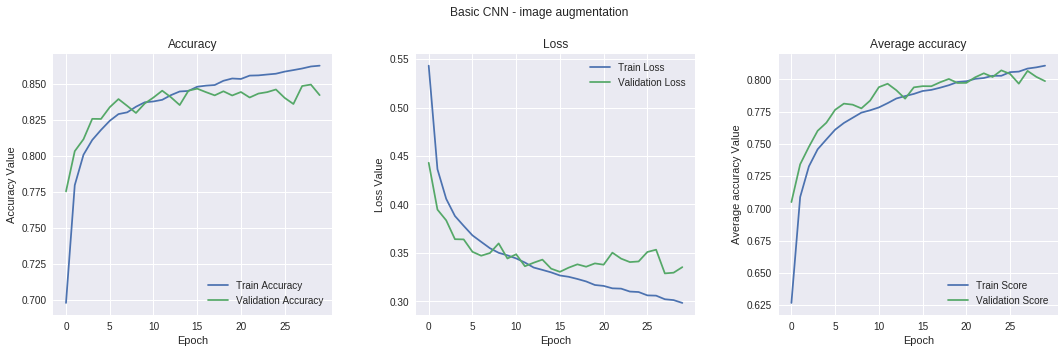

In [0]:
# Read saved history data from basic cnn model with image augmentation
df = pd.read_csv('History_basic_cnn_aug.csv')
f = model_history_plot(df, n_epochs=30, title="Basic CNN - image augmentation")

We clearly observe that this model does not overfit as the accuracies and the losses of the training and validation sets are very similar. Consequently, this model generalizes much better compared to the previous two ones thanks to data augmentation.

## Transfer learning

In the following, we apply different strategies of transfer learning based on the well known ResNet-50 model. We use the pre-trained weights obtained from the ImageNet database (containing over a million images with 1000 categories).

### Fine tuning the classification layer (TL1)

In [0]:
input_shape = (56, 56, 3)

# Use ResNet50 and remove the last layer 
resnet = ResNet50(include_top=False, weights='imagenet', input_shape = input_shape)

# Set all the weights to be non trainable
for layer in resnet.layers:
    layer.trainable = False
    
# Verify that all layers are set to non trainable
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f3ce83cc208>,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7f3ce83cc780>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7f3ce83cc9b0>,conv1,False
3,<keras.layers.normalization.BatchNormalization object at 0x7f3ce320aba8>,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7f3d3baf26a0>,activation_1,False
5,<keras.layers.convolutional.ZeroPadding2D object at 0x7f3ce47fc160>,pool1_pad,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f3ce16a5898>,max_pooling2d_1,False
7,<keras.layers.convolutional.Conv2D object at 0x7f3ce3214b70>,res2a_branch2a,False
8,<keras.layers.normalization.BatchNormalization object at 0x7f3cd95bf0f0>,bn2a_branch2a,False
9,<keras.layers.core.Activation object at 0x7f3cd95bf198>,activation_2,False


In [0]:
#Adding custom layers to classification unit
out = resnet.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(1, activation='sigmoid')(out)

# creating the final model 
model = Model(inputs= resnet.input, outputs=predictions)

# compile the model 
model.compile(optimizer=optimizers.Adam(lr=1e-4),              
              loss='binary_crossentropy',
              metrics=['accuracy', w_acc])

model.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 56, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 62, 62, 3)    0           input_1[0][0]                    
_______________________________________________________________________

In [0]:
# Create train generator
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,  zoom_range=0.1, rotation_range=10,
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size= batch_size, seed=1)

# Create validation generator
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

val_generator = val_datagen.flow(x_val, y_val, shuffle=False, batch_size=BATCH_SIZE, seed=1)  

In [0]:
run_cnn_model('resnet50_TL1', train_generator, train_steps_per_epoch,
                  val_generator, val_steps_per_epoch, val_datagen,
                  x_test, test_steps_per_epoch,
                  model, n_epochs = 15)

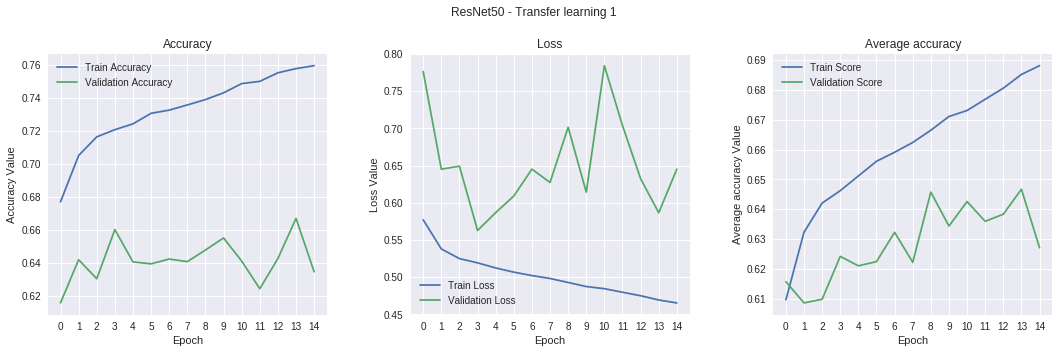

In [0]:
df = pd.read_csv('History_resnet50_TL1.csv')
f = model_history_plot(df, n_epochs=15, title="ResNet50 - Transfer learning 1")

We get a model with a very low validation average accuracy below 65 % and a relatively bad training average accuracy ( <70 %). In addition, the model clearly overfits as there is a significant gap between the training and validation accuracies even after the first epoch. The overfitting has not been resolved by the image augmentation. This model is so far the worst one. Including some regularization after each hidden dense layer would have probably improved the result together with a smaller learning rate. Another option could have been to start from weights which were not extracted from ImageNet but from a more appropriate database such as FaceNet.


###	Freezing 158 layers (TL2)

In [0]:
input_shape = (56, 56, 3)

# Use ResNet50 and remove the last layer 
resnet = ResNet50(include_top=False, weights='imagenet', input_shape = input_shape)

# Set the first 158 layers (before res5b_branch2b block) of the network to be non-trainable
for layer in resnet.layers[:158]:
  layer.trainable=False
    
# Verify that only the first 158 layers are set to non trainable
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f1eee1a5438>,input_2,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7f1eee0c63c8>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7f1eee0c6a20>,conv1,False
3,<keras.layers.normalization.BatchNormalization object at 0x7f1eee112390>,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7f1eee0e1748>,activation_50,False
5,<keras.layers.convolutional.ZeroPadding2D object at 0x7f1eee27aef0>,pool1_pad,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f1eee385400>,max_pooling2d_2,False
7,<keras.layers.convolutional.Conv2D object at 0x7f1eee1e01d0>,res2a_branch2a,False
8,<keras.layers.normalization.BatchNormalization object at 0x7f1eedfda320>,bn2a_branch2a,False
9,<keras.layers.core.Activation object at 0x7f1eedfdac88>,activation_51,False


In [0]:
#Adding custom layers to classification unit
out = resnet.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(1, activation='sigmoid')(out)

# creating the final model 
model = Model(inputs= resnet.input, outputs=predictions)

# compile the model 
model.compile(optimizer=optimizers.Adam(lr=1e-4),              
              loss='binary_crossentropy',
              metrics=['accuracy', w_acc])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 56, 56, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 62, 62, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 28, 28, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 28, 28, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
run_cnn_model('resnet50_TL2', train_generator, train_steps_per_epoch,
                  val_generator, val_steps_per_epoch, val_datagen,
                  x_test, test_steps_per_epoch,
                  model, n_epochs = 30)

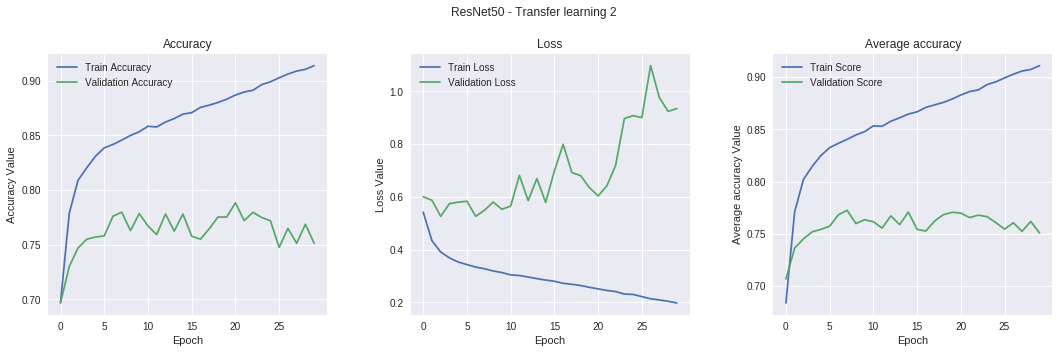

In [0]:
df = pd.read_csv('History_resnet50_TL2.csv')
f = model_history_plot(df, n_epochs=30, title="ResNet50 - Transfer learning 2")

The validation accuracy has now improved to above 75 %. However, the presence of overfitting clearly appears due to the gap between the training and validation accuracies after the fifth epoch. Let’s try to see whether this can be improved by training from scratch the ResNet-50 network by using pre-trained weights as initialization for all the layers of the architecture.

### Training from scratch (TL3)

In [0]:
input_shape = (56, 56, 3)

# Use ResNet50 and remove the last layer 
resnet = ResNet50(include_top=False, weights='imagenet', input_shape = input_shape)

# Set all the weights to be trainable
for layer in resnet.layers:
    layer.trainable = True
    
# Verify that all layers are set to be trainable
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f1ee63ce0f0>,input_3,True
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7f1ee63ce978>,conv1_pad,True
2,<keras.layers.convolutional.Conv2D object at 0x7f1ee63ce390>,conv1,True
3,<keras.layers.normalization.BatchNormalization object at 0x7f1ee63cedd8>,bn_conv1,True
4,<keras.layers.core.Activation object at 0x7f1ee63ba7b8>,activation_99,True
5,<keras.layers.convolutional.ZeroPadding2D object at 0x7f1ee63449b0>,pool1_pad,True
6,<keras.layers.pooling.MaxPooling2D object at 0x7f1ee632b9e8>,max_pooling2d_3,True
7,<keras.layers.convolutional.Conv2D object at 0x7f1ee63d95c0>,res2a_branch2a,True
8,<keras.layers.normalization.BatchNormalization object at 0x7f1ee62794e0>,bn2a_branch2a,True
9,<keras.layers.core.Activation object at 0x7f1ee6279cc0>,activation_100,True


In [0]:
#Adding custom layers to classification unit
out = resnet.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(1, activation='sigmoid')(out)

# creating the final model 
model = Model(inputs= resnet.input, outputs=predictions)

# compile the model 
model.compile(optimizer=optimizers.Adam(lr=1e-4),              
              loss='binary_crossentropy',
              metrics=['accuracy', w_acc])

model.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 56, 56, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 62, 62, 3)    0           input_3[0][0]                    
_______________________________________________________________________

In [0]:
# Create train generator
BATCH_SIZE = 512
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,  zoom_range=0.1, rotation_range=10,
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size= batch_size, seed=1)

# Create validation generator
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)#rescale=1./255)

val_generator = val_datagen.flow(x_val, y_val, shuffle=False, batch_size=BATCH_SIZE, seed=1)     


In [0]:
run_cnn_model('resnet50_TL3', train_generator, train_steps_per_epoch,
                  val_generator, val_steps_per_epoch, val_datagen,
                  x_test, test_steps_per_epoch,
                  model, n_epochs = 15)

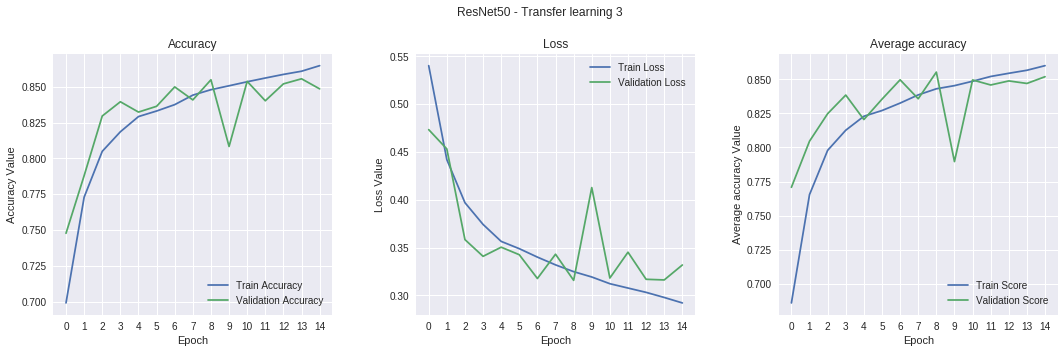

In [0]:
df = pd.read_csv('History_resnet50_TL3.csv')
f = model_history_plot(df, n_epochs=15, title="ResNet50 - Transfer learning 3")

The results have now improved significantly compared to the previous two models. The overfitting phenomenon has disappeared and we achieve the best average accuracy so far (around 85 %). Nonetheless, this is the most expensive model to train in terms of weight computations and operations.

## Comparison of the models

### Useful functions

In [0]:
# Functions for displaying metrics functions
def get_metrics(true_labels, predicted_labels):

    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    
    print('Challenge Score:', np.round(compute_pred_score(true_labels, 
                                                   predicted_labels),
                                 4))                 
                        

def plot_confusion_matrix(y_true, y_pred, classes,                                                    
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")    
    ax.grid(False)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()    
    return ax
  
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)    
    plot_confusion_matrix(y_true=true_labels,
                      y_pred=predicted_labels,
                      classes= classes)

### Model loading

In [0]:
basic_cnn = load_model('basic_cnn.h5', custom_objects={'w_acc': w_acc})
basic_cnn_reg = load_model('basic_cnn_reg.h5', custom_objects={'w_acc': w_acc})
basic_cnn_aug = load_model('basic_cnn_aug.h5', custom_objects={'w_acc': w_acc})
resnet50_TL1 = load_model('resnet50_TL1.h5', custom_objects={'w_acc': w_acc})
resnet50_TL2 = load_model('resnet50_TL2.h5', custom_objects={'w_acc': w_acc})
resnet50_TL3 = load_model('resnet50_TL3.h5', custom_objects={'w_acc': w_acc})

### Model 1: basic cnn (B1)

Model Performance metrics:
------------------------------
Precision: 0.8267
Recall: 0.8202
F1 Score: 0.8215
Challenge Score: 0.8233

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79     14144
         1.0       0.88      0.81      0.84     20625

   micro avg       0.82      0.82      0.82     34769
   macro avg       0.81      0.82      0.82     34769
weighted avg       0.83      0.82      0.82     34769


Prediction Confusion Matrix:
------------------------------
Confusion matrix, without normalization


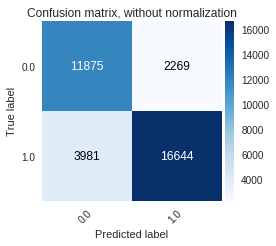

In [71]:
predictions_1 = np.round(basic_cnn.predict_generator(test_gen(x_test, val_datagen, 1), 
                                      val_samples=x_test.shape[0],
                                      verbose = 1))

display_model_performance_metrics(true_labels=y_test,
                                  predicted_labels=predictions_1,
                                  classes= list(set(y_test)))

### Model 2: basic cnn with regularization (B2)

Model Performance metrics:
------------------------------
Precision: 0.8457
Recall: 0.8451
F1 Score: 0.8453
Challenge Score: 0.8412

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81     14144
         1.0       0.88      0.86      0.87     20625

   micro avg       0.85      0.85      0.85     34769
   macro avg       0.84      0.84      0.84     34769
weighted avg       0.85      0.85      0.85     34769


Prediction Confusion Matrix:
------------------------------
Confusion matrix, without normalization


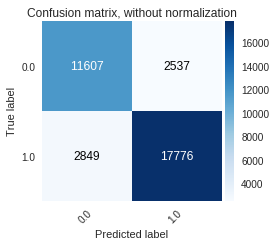

In [74]:
predictions_2 = np.round(basic_cnn_reg.predict_generator(test_gen(x_test, val_datagen, 1), 
                                      val_samples=x_test.shape[0],
                                      verbose = 1))

display_model_performance_metrics(true_labels=y_test,
                                  predicted_labels=predictions_2,
                                  classes= list(set(y_test)))

### Model 3: basic cnn with regularization and image augmentation (B3)

Model Performance metrics:
------------------------------
Precision: 0.8495
Recall: 0.8455
F1 Score: 0.8464
Challenge Score: 0.8469

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.78      0.85      0.82     14144
         1.0       0.89      0.84      0.87     20625

   micro avg       0.85      0.85      0.85     34769
   macro avg       0.84      0.85      0.84     34769
weighted avg       0.85      0.85      0.85     34769


Prediction Confusion Matrix:
------------------------------
Confusion matrix, without normalization


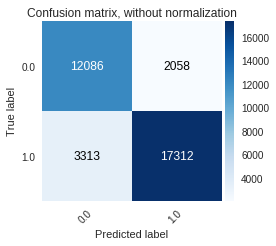

In [76]:
predictions_3 = np.round(basic_cnn_aug.predict_generator(test_gen(x_test, val_datagen, 1), 
                                      val_samples=x_test.shape[0],
                                      verbose = 1))

display_model_performance_metrics(true_labels=y_test,
                                  predicted_labels=predictions_3,
                                  classes= list(set(y_test)))

### Model 4: Res-Net50 Transfer Learning 1 (TL1)

Model Performance metrics:
------------------------------
Precision: 0.655
Recall: 0.6577
F1 Score: 0.6299
Challenge Score: 0.6092

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.65      0.35      0.45     14144
         1.0       0.66      0.87      0.75     20625

   micro avg       0.66      0.66      0.66     34769
   macro avg       0.65      0.61      0.60     34769
weighted avg       0.66      0.66      0.63     34769


Prediction Confusion Matrix:
------------------------------
Confusion matrix, without normalization


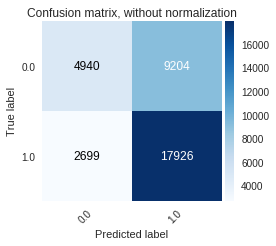

In [30]:
predictions_4 = np.round(resnet50_TL1.predict_generator(test_gen(x_test, val_datagen, 1), 
                                      val_samples=x_test.shape[0],
                                      verbose = 1))

display_model_performance_metrics(true_labels=y_test,
                                  predicted_labels=predictions_4,
                                  classes= list(set(y_test)))

### Model 5: Res-Net50 Transfer Learning 2 (TL2)

Model Performance metrics:
------------------------------
Precision: 0.7528
Recall: 0.748
F1 Score: 0.7494
Challenge Score: 0.746

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.67      0.74      0.70     14144
         1.0       0.81      0.76      0.78     20625

   micro avg       0.75      0.75      0.75     34769
   macro avg       0.74      0.75      0.74     34769
weighted avg       0.75      0.75      0.75     34769


Prediction Confusion Matrix:
------------------------------
Confusion matrix, without normalization


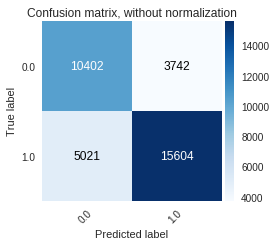

In [36]:
predictions_5 = np.round(resnet50_TL2.predict_generator(test_gen(x_test, val_datagen, 1), 
                                      val_samples=x_test.shape[0],
                                      verbose = 1))

display_model_performance_metrics(true_labels=y_test,
                                  predicted_labels=predictions_5,
                                  classes= list(set(y_test)))

### Model 6: Res-Net50 Transfer Learning 3 (TL3)

Model Performance metrics:
------------------------------
Precision: 0.8511
Recall: 0.8463
F1 Score: 0.8472
Challenge Score: 0.8487

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82     14144
         1.0       0.90      0.84      0.87     20625

   micro avg       0.85      0.85      0.85     34769
   macro avg       0.84      0.85      0.84     34769
weighted avg       0.85      0.85      0.85     34769


Prediction Confusion Matrix:
------------------------------
Confusion matrix, without normalization


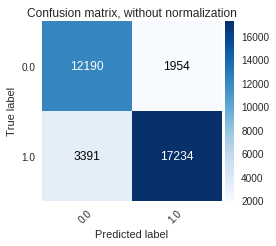

In [43]:
predictions_6 = np.round(resnet50_TL3.predict_generator(test_gen(x_test, val_datagen, 1), 
                                      val_samples=x_test.shape[0],
                                      verbose = 1))

display_model_performance_metrics(true_labels=y_test,
                                  predicted_labels=predictions_6,
                                  classes= list(set(y_test)))


### Comments

The worst model is the one where I only fine tuned the classification unit from ResNet-50 (TL1) and the best model is the ResNet-50 trained from scratch (TL3). The confusion matrices displayed above show some interesting results. For example, it appears from the diagonal of these matrices that the worst model (TL1) gives the best predictions of the labels from class 1 compared to all the other models. The best model (TL3) gives the best predictions associated to class 0. Perhaps, a combination of the two models would have helped improving the results. Regarding the more basic models, techniques such as regularization and image augmentation (model B3) definitely helped improving the averaged accuracy obtained on the test set.
All in all, model B3 is performing almost as well as model TL3. However, in terms of computational efficiency, the basic model outperforms. Consequently, I have finally decided to use model B3 to predict the final test set provided during the second phase of the challenge.


# Training a model for predicting the final test

In order to predict the labels on the test set provided during the second phase, I switched to TPU and changed the code accordingly. As explained above, I decided to use model B3 for this purpose because of its good accuracy and its computational efficiency in terms of number of operations and weights to compute.

## Training

In [0]:
# Keras library import with tensorflow prefix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dropout, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform, he_normal
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [0]:
## Redefinig model B1
input_shape = (56, 56, 3)
X_in = Input(shape = input_shape, name='Input')
X = Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape)(X_in)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Conv2D(64, kernel_size=(3, 3), activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Conv2D(128, kernel_size=(3, 3), activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.3)(X)
X_out = Dense(1, activation='sigmoid')(X)

model = Model(inputs=X_in, outputs=X_out)

In [0]:
# Create train generator
BATCH_SIZE = 124
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size


train_datagen = ImageDataGenerator(rescale=1./255,  zoom_range=0.1, rotation_range=10,
                                   horizontal_flip=True, fill_mode='nearest')

#train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size= batch_size, seed=1)
train_generator = train_datagen.flow(train_data,  new_train_images_label, shuffle=False, batch_size= batch_size, seed=1)

# Create validation generator
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(x_val, y_val, shuffle=False, batch_size=BATCH_SIZE, seed=1)   

In [0]:
# Model compile (only accuracy metric is measured)
reducelr = ReduceLROnPlateau(factor=0.1, patience=15, min_lr=1e-7, verbose=1)
model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(lr=1e-4),
              metrics=['accuracy'],
              callbacks=[reducelr])

In [0]:
# TPU Settings
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

tpu_model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data = val_generator,
    validation_steps = val_steps_per_epoch,
    epochs=100,
)

In [0]:
# Save weights from tpu_model
tpu_model.save_weights('Final_model.h5', overwrite=True)

## Loading test set and prepare final predictions

In [0]:
# Loading final predictions
!wget https://www.dropbox.com/s/mnido8qbwmbi79h/db_test.raw?dl=1
!mv db_test.raw?dl=1 db_test.raw

test_images_fname = 'db_test.raw'
image_dim = 56 * 56 * 3
# number of images
num_test_images = 59429
with open(test_images_fname, 'rb') as f:
    test_images_data = np.fromfile(f, dtype=np.uint8, count=num_test_images * image_dim).astype(np.uint8)
    test_images_data = test_images_data.reshape(num_test_images, image_dim)

In [7]:
# dHash applied to test data
L_dhash_test = []

for i in range(test_images_data.shape[0]):
  L_dhash_test.append(dhash(Image.fromarray(test_images_data[i].reshape(56, 56,3), 'RGB')))

print("Total number of hashes validation dataset:", len(L_dhash_test))
print("Unique hashes in validation dataset:", len(np.unique(L_dhash_test)))

Total number of hashes validation dataset: 59429
Unique hashes in validation dataset: 59371


In [14]:
print("Unique hashes in test dataset:", len(np.unique(L_dhash_test)))
print("Number of elements from test set that are common to training set:", len(list(set(L_dhash_test).intersection(L_dhash_train))))

Unique hashes in test dataset: 59371
Number of elements from test set that are common to training set: 213


Let's display some of the duplications between the train and the final test set.

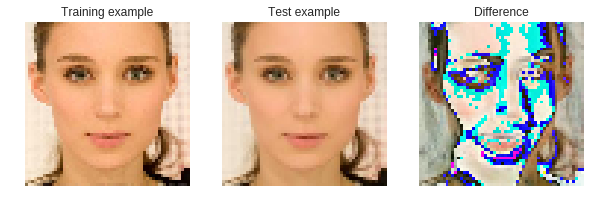

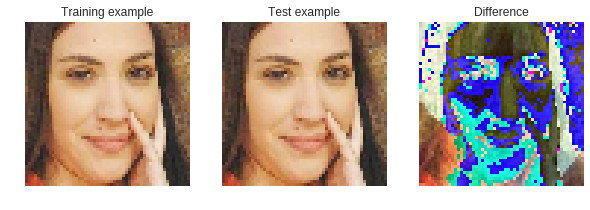

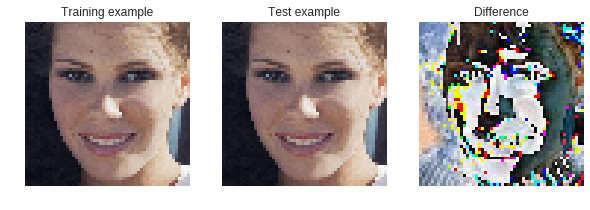

In [32]:
# Display duplications
for i in range(3):
  plt.figure(figsize=(10,4))
  plt.subplot(131)
  plt.axis('off')
  hash_ex = list(set(L_dhash_test).intersection(L_dhash_train))[i]
  idx = np.where(np.asarray(L_dhash_train) == hash_ex)[0][0] 
  plt.imshow(train_images_data[idx].reshape(56, 56,3).astype(np.uint8))
  plt.title('Training example')
  plt.subplot(132)
  plt.axis('off')
  idx = np.where(np.asarray(L_dhash_test) == hash_ex)[0][0] 
  plt.imshow(test_images_data[idx].reshape(56, 56,3).astype(np.uint8))
  plt.title('Test example')
  plt.subplot(133)
  plt.axis('off')
  idx = np.where(np.asarray(L_dhash_test) == hash_ex)[0][0] 
  plt.imshow(test_images_data[idx].reshape(56, 56,3).astype(np.uint8) - train_images_data[idx].reshape(56, 56,3).astype(np.uint8))
  plt.title('Difference')

## Prepare predictions and submit

In [0]:
# Redefine prediction model
input_shape = (56, 56, 3)
Xp_in = Input(shape = input_shape, name='Input')
Xp = Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape)(Xp_in)
Xp = MaxPooling2D(pool_size=(2, 2))(Xp)
Xp = Conv2D(64, kernel_size=(3, 3), activation='relu')(Xp)
Xp = MaxPooling2D(pool_size=(2, 2))(Xp)
Xp = Conv2D(128, kernel_size=(3, 3), activation='relu')(Xp)
Xp = MaxPooling2D(pool_size=(2, 2))(Xp)
Xp = Flatten()(Xp)
Xp = Dense(512, activation='relu')(Xp)
Xp = Dropout(0.3)(Xp)
Xp = Dense(512, activation='relu')(Xp)
Xp = Dropout(0.3)(Xp)
Xp_out = Dense(1, activation='sigmoid')(Xp)

prediction_model = Model(inputs=Xp_in, outputs=Xp_out)

prediction_model.summary()

In [0]:
# Load weights from tpu model
prediction_model.load_weights('Final_model.h5')

In [0]:
# Derive predictions from final test set
y_pred = np.round(prediction_model.predict_generator(test_gen(test_images_data.reshape(test_images_data.shape[0],56, 56,3), val_datagen),
                                                     steps=test_images_data.shape[0], verbose=1))

In [0]:
# Replace the model predictions in the test data by the labels from the training set for the duplicates
intersept_dhash = set(L_dhash_test).intersection(set(L_dhash_train))
test_ind = [i for i in range(test_images_data.shape[0]) if L_dhash_test[i] in intersept_dhash]
train_ind = [i for i in range(train_images_data.shape[0]) if L_dhash_train[i] in intersept_dhash]
combi_dhash = [(i,j) for i in test_ind for j in train_ind if L_dhash_test[i] == L_dhash_train[j]]
for i in range(len(combi_dhash)):
  y_pred[combi_dhash[i][0]] = train_images_label[combi_dhash[i][1]]

In [0]:
np.savetxt("y_pred.txt", y_pred, fmt="%d")

# Hidden feature

Let's plot the average images associated to class 1 and 0 for the training set.

Text(0.5, 1.0, 'Class 0')

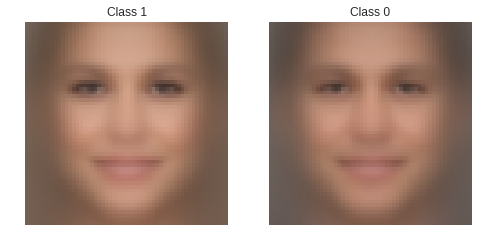

In [5]:
f = plt.figure(figsize=(8,5))
plt.subplot(121)
plt.imshow(np.mean(train_images_data.reshape(train_images_data.shape[0], 56, 56, 3)[train_images_label==1], axis=0) * (1 / 255))
plt.axis('off')
plt.title('Class 1')
plt.subplot(122)
plt.imshow(np.mean(train_images_data.reshape(train_images_data.shape[0], 56, 56, 3)[train_images_label==0], axis=0) * (1 / 255))
plt.axis('off')
plt.title('Class 0')


It clearly appears that images from class 1 are characterized by female features whereas images from class 0 have male features. I have noticed that there were several male faces in class 1 and several female faces in class 0, so this problem was not a gender classification one.

Let's now look at the feature maps extracted for two images from the training set belonging to class 1 and 0.

In [0]:
layer_outputs = [prediction_model.get_layer('conv2d_1').output,#model.get_layer('Input').output, 
                  prediction_model.get_layer('max_pooling2d_1').output, prediction_model.get_layer('conv2d_2').output,
                  prediction_model.get_layer('max_pooling2d_2').output, prediction_model.get_layer('conv2d_3').output,
                  prediction_model.get_layer('max_pooling2d_3').output]


activation_model = models.Model(inputs=prediction_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input


In [0]:
activations_0 = activation_model.predict(img_tensor_0) 
activations_1 = activation_model.predict(img_tensor_1) 

In [0]:
images_per_row = 16

layer_names = ['conv2d_1','conv2d_2','conv2d_3']

def display_feaure_amps(activations_class, class_idx):
  for layer_name, layer_activation in zip(layer_names, activations_class): # Displays the feature maps
      n_features = layer_activation.shape[-1] # Number of features in the feature map
      size1 = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
      size2 = layer_activation.shape[2] #The feature map has shape (1, size, size, n_features).
      n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
      display_grid = np.zeros((size1 * n_cols, images_per_row * size2))
      for col in range(n_cols): # Tiles each filter into a big horizontal grid
          for row in range(images_per_row):
              #print(col * images_per_row + row)
              channel_image = layer_activation[0,
                                               :, :,
                                               col * images_per_row + row]
              channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')            
              display_grid[col * size1 : (col + 1) * size1, # Displays the grid
                           row * size2 : (row + 1) * size2] = channel_image
      scale1 = 1. / size1
      scale2 = 1. / size2
      plt.figure(figsize=(scale1 * display_grid.shape[1],
                          scale2 * display_grid.shape[0]))    
      plt.title(f'Class {class_idx}: {layer_name}')
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


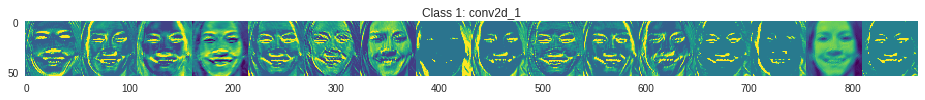

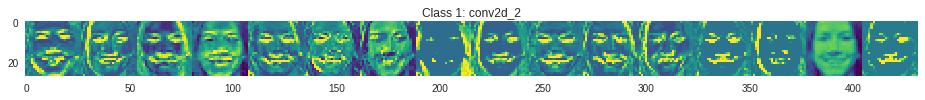

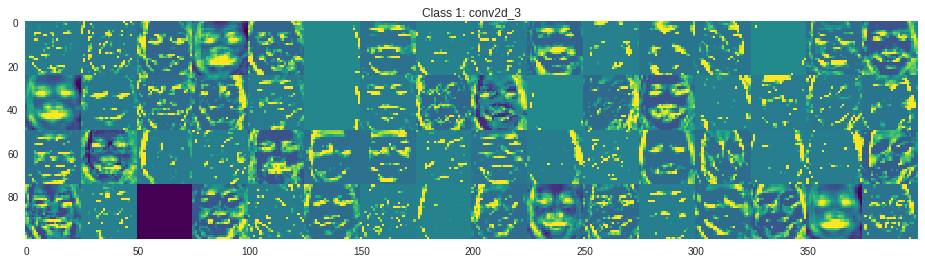

In [30]:
display_feaure_amps(activations_1, class_idx=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


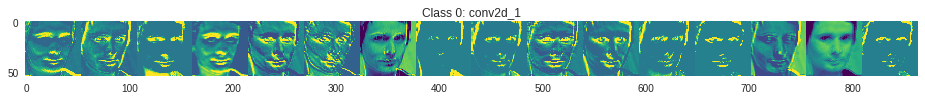

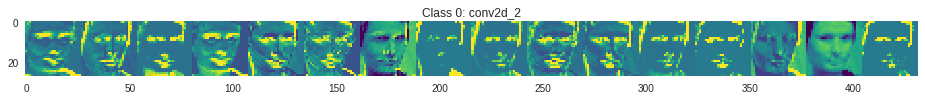

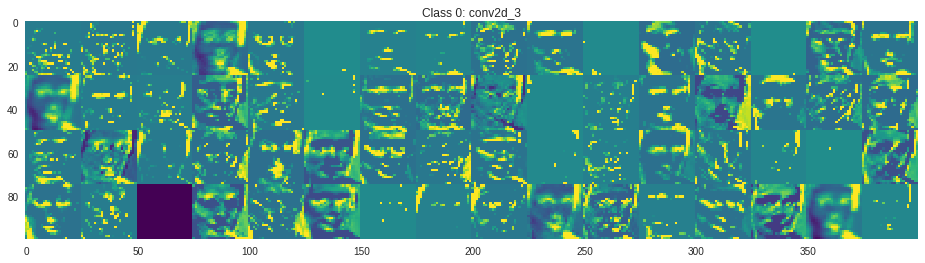

In [31]:
display_feaure_amps(activations_0, class_idx=0)

Looking at the above feature maps does not seem to help on identifying which type of characteristic is specifically related to class 0 or 1. Let's try to examine  what are the regions from the image that contribute most towards a change in the output of the CNN. For this, let's plot saliency maps.

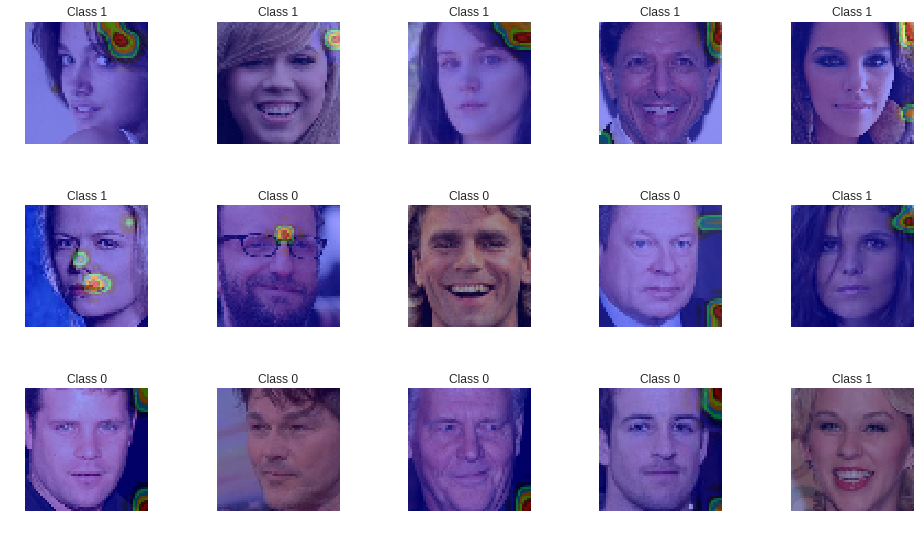

In [120]:
# Let's look at the output from the last convolution layer named 'conv2d_3'
penultimate_layer = utils.find_layer_idx(prediction_model, 'conv2d_3')
layer_idx = utils.find_layer_idx(prediction_model, 'conv2d_3')

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 9),squeeze = False)
fig.subplots_adjust(hspace = 0.5,wspace = 0.5)
rnd.seed(0)

for row in axes:
  for ax in row:
      i = rnd.randint(0, train_images_data.shape[0])
      img = train_images_data.reshape(train_images_data.shape[0], 56, 56, 3)[i]
      grads = visualize_cam(prediction_model, layer_idx, filter_indices=20, 
                            seed_input=img, penultimate_layer_idx=penultimate_layer,
                            backprop_modifier=None) 
      jet_heatmap = np.uint8((cm.jet(grads))[..., 0] * 255)
      ax.imshow(overlay(jet_heatmap, img, alpha=0.4))            
      ax.set_title(f"Class {int(train_images_label[i])}")
      ax.axis('off')      


It appears that the pixels from the corner of the images are typically the ones that get activated after using the CNN architecture B3. The ones from the top right corner, where you may have some hair are often activated when we have class 1 images. Perhaps the hidden feature has to do with a combination of female or male face features coupled with some hair characteristics.

# Conclusion

The image classification problem considered in this challenge was not an easy one. In the end, the first person of the leader board achieved 0.87 in accuracy. The problem was even more difficult to address without knowing which property was behind all the images. The analysis of the different examples did not allow to confidently conclude on which type of hidden feature I was trying to classify for.
As the challenge was related to computer vision, it seemed natural to use CNNs, that is why several architectures were tested. In the end, with a relatively simple one, an acceptable accuracy was obtained (0.858976) without needing to compute several millions of parameters as it was the case when using transfer learning approaches.
